In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF 
import numpy as np
from sklearn.metrics import mean_absolute_error
import math
import os


In [2]:
def calculate_distance_to_line(xp, yp, yaw, x1=0.749876, y1=-2.240269, x2=0.811162, y2=-0.986052):
    yaw_radians = math.radians(yaw)
    # 计算直线的斜率 k 和截距 b
    k = (y2 - y1) / (x2 - x1)
    b = y1 - k * x1
    # 计算射线的斜率 m 和截距 c
    m = math.tan(yaw_radians)
    c = yp - m * xp
    # 计算交点
    if k != m:  # 确保斜率不相同，防止平行线
        x_intersect = (c - b) / (k - m)
        y_intersect = k * x_intersect + b
        # 计算距离
        distance = math.sqrt((x_intersect - xp)**2 + (y_intersect - yp)**2)
    else:
        distance = float('inf')  # 平行线没有交点
    return distance




def process_data(file_paths):
    # Initialize empty lists to store data
    whisker1_data = []
    whisker2_data = []
    laser1_data = []
    laser2_data = []
    GT1_data = []
    GT2_data = []
    orientation_data = []
    position_data = []

    for file_path in file_paths:
        # Read data from file
        data = pd.read_csv(file_path)
        
        # Extract data columns
        whisker1_data.append(data.iloc[:, 13:16].values)
        whisker2_data.append(data.iloc[:, 16:19].values)
        laser1 = data.iloc[:, -5].values+20*np.tan(np.radians(np.rad2deg(data.iloc[:, -1])-2.8))
        laser2 = data.iloc[:, -5].values-20*np.tan(np.radians(np.rad2deg(data.iloc[:, -1])-2.8))
        laser1_data.append( np.where(laser1 > 217, 0, 217 - laser1))
        laser2_data.append( np.where(laser2 > 217, 0, 217 - laser2))
        GT = data.apply(lambda row: calculate_distance_to_line(row.iloc[-2], row.iloc[-4], np.rad2deg(row.iloc[-1])-2.8), axis=1) * 1000
        GT1 = GT+20*np.tan(np.radians(np.rad2deg(data.iloc[:, -1])-2.8))
        GT2 = GT-20*np.tan(np.radians(np.rad2deg(data.iloc[:, -1])-2.8))
        GT1_data.append( np.where(GT1 > 240, 0, 240 - GT1))
        GT2_data.append( np.where(GT2 > 240, 0, 240 - GT2))
        orientation_data.append(data.iloc[:, -6].values)
        position_data.append(data.iloc[:, 1:3].values)
    
    # Concatenate data from all files
    whisker1_data = np.concatenate(whisker1_data)
    whisker2_data = np.concatenate(whisker2_data)
    laser1_data = np.concatenate(laser1_data)
    laser2_data = np.concatenate(laser2_data)
    GT1_data = np.concatenate(GT1_data)
    GT2_data = np.concatenate(GT2_data)
    orientation_data = np.concatenate(orientation_data)
    position_data = np.concatenate(position_data)
    
    return whisker1_data, whisker2_data, laser1_data, laser2_data, GT1_data, GT2_data, orientation_data, position_data

def filter_data_both(whisker_data1, whisker_data2, laser1_data,laser2_data, GT_data1, GT_data2, threshold, orientation_data, position_data):
    filter_indices = (whisker_data1[:,0] >= threshold) & (whisker_data2[:,0] >= threshold) & (GT_data1 > 0) & (GT_data2 > 0)
    whisker1_filtered = whisker_data1[filter_indices]
    whisker2_filtered = whisker_data2[filter_indices]
    laser1_filtered = laser1_data[filter_indices]
    laser2_filtered = laser2_data[filter_indices]
    GT1_filtered = GT_data1[filter_indices]
    GT2_filtered = GT_data2[filter_indices]
    orientation_filtered = orientation_data[filter_indices]
    position_filtered = position_data[filter_indices]
    return whisker1_filtered, whisker2_filtered, laser1_filtered,laser2_filtered, GT1_filtered, GT2_filtered, orientation_filtered, position_filtered

In [3]:
from sklearn.preprocessing import StandardScaler

file_paths = ['20241209-2/data1.csv', '20241209-2/data17.csv', '20241209-2/data2.csv', '20241209-2/data16.csv', 
              '20241209-2/data10.csv', '20241209-2/data15.csv', '20241209-2/data5.csv', '20241209-2/data14.csv', 
              '20241209-2/data9.csv', '20241209-2/data13.csv', '20241209-2/data6.csv', '20241209-2/data12.csv', 
              '20241209-2/data7.csv', '20241209-2/data11.csv', '20241209-2/data3.csv', '20241209-2/data4.csv',
              '20241209-2/data8.csv', '20241209-2/data18.csv']
train_whisker1, train_whisker2, train_laser1, train_laser2, train_GT1, train_GT2, train_orientation, train_position= process_data(file_paths[:17])
test_whisker1, test_whisker2, test_laser1, test_laser2, test_GT1, test_GT2, test_orientation, test_position = process_data(file_paths[14:17])

train_whisker1_filtered, train_whisker2_filtered, train_laser1_filtered,train_laser2_filtered, train_GT1_filtered,train_GT2_filtered, train_orientation_filtered, _ = filter_data_both(train_whisker1, train_whisker2, train_laser1, train_laser2, train_GT1, train_GT2, 10, train_orientation, train_position)
test_whisker1_filtered, test_whisker2_filtered, test_laser1_filtered, test_laser2_filtered, test_GT1_filtered, test_GT2_filtered, test_orientation_filtered, test_position_filtered = filter_data_both(test_whisker1, test_whisker2, test_laser1, test_laser2, test_GT1, test_GT2, 10, test_orientation, test_position)

scaler = StandardScaler()
train_whisker1_filtered_N = scaler.fit_transform(train_whisker1_filtered)
test_whisker1_filtered_N = scaler.transform(test_whisker1_filtered)
mean_train = scaler.mean_
std_train = scaler.scale_
print(mean_train)
print(std_train)
train_whisker2_filtered_N = scaler.fit_transform(train_whisker2_filtered)
test_whisker2_filtered_N = scaler.transform(test_whisker2_filtered)
mean_train = scaler.mean_
std_train = scaler.scale_
print(mean_train)
print(std_train)

filtered_data_counts = np.zeros((len(file_paths), 1), dtype=int)  # 2表示有两个过滤后的数据
for i, file_path in enumerate(file_paths):
    whisker1, whisker2, laser1, laser2, GT1, GT2, orientation, position = process_data([file_path])
    
    # 进行数据过滤
    whisker_filtered, _, _,_, _,_, _, _ = filter_data_both(whisker1, whisker2, laser1, laser2, GT1, GT2, 10, orientation, position)
    
    # 计算过滤后的数量并存储到数组中
    filtered_data_counts[i] = [whisker_filtered.shape[0]]
print(filtered_data_counts )

[ 38.54624973   0.55249265 -23.19183939]
[14.80891291  2.27739256 10.36294479]
[55.96984826 -3.6516308  -1.02449511]
[19.93779949  5.61960992 11.38879418]
[[188]
 [177]
 [181]
 [180]
 [173]
 [174]
 [163]
 [182]
 [188]
 [179]
 [175]
 [169]
 [183]
 [179]
 [164]
 [179]
 [172]
 [180]]


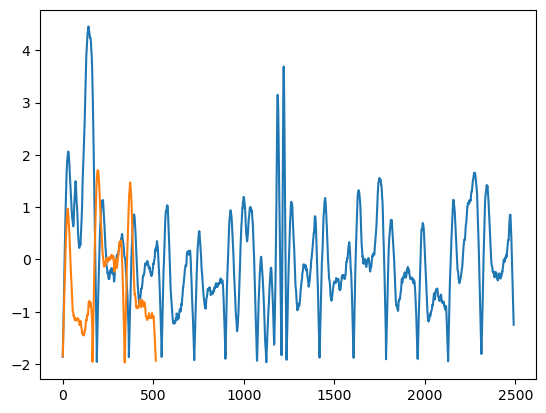

In [190]:
# plt.plot( train_GT1_filtered, label='gt')
# plt.legend()
plt.plot( train_whisker1_filtered_N[:,0])
plt.plot( test_whisker1_filtered_N[:,0])

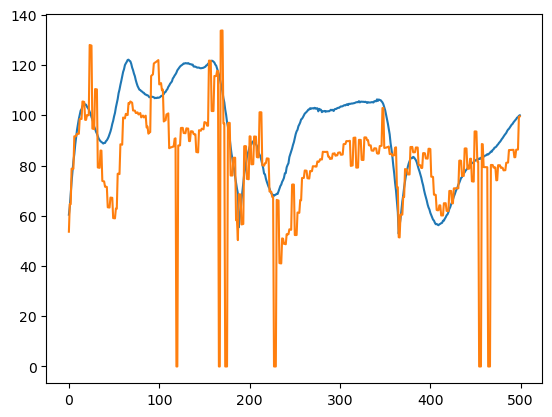

In [246]:
# plt.plot( test_whisker1_filtered)
plt.plot( train_GT1_filtered[:500], label='gt')
plt.plot( train_laser1_filtered[:500], label='gt')
# plt.plot( test_whisker1_filtered[:,0])

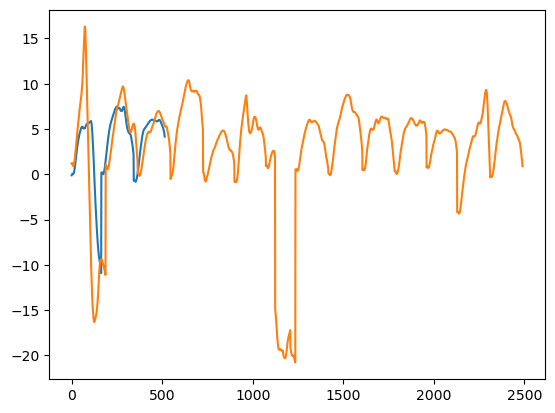

In [192]:
plt.plot(test_orientation_filtered)
plt.plot(train_orientation_filtered)

In [229]:
#whisker1 MLP Train, validation, test
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
import copy
from train import *
from model import *
from utils import *
from sklearn.model_selection import train_test_split 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#网格搜索法寻找最佳超参数组合，并在验证集上进行验证
input_size = 3 # 输入特征维度
output_size = 1 # 输出类别数
num_layers = 3  # MLP 层数
hidden_size= 32
# time_sequence_values = [40]  # 时间序列长度取值范围

best_model = None
best_loss = float('inf')
best_loss_fold = float('inf')
best_params = None
best_mean_performance = float('inf')
criterion = nn.L1Loss()

train_whisker_tensor = torch.Tensor(train_whisker1_filtered_N)
train_GT_tensor = torch.Tensor(train_GT1_filtered)
train_laser_tensor = torch.Tensor(train_laser1_filtered)
train_whisker_tensor , test_whisker_tensor, train_GT_tensor, test_GT_tensor,train_laser_tensor, test_laser_tensor = train_test_split(train_whisker_tensor, train_GT_tensor, train_laser_tensor, test_size=0.2, random_state=0)

train_dataset = TensorDataset(train_whisker_tensor, train_GT_tensor)
test_dataset = TensorDataset(test_whisker_tensor, test_GT_tensor)  

# Fixed hyperparameters
batch_size = 32
learning_rate = 0.001
regularization = 0.001
dropout = 0.1
num_epochs = 50

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
model = MLP(input_size, hidden_size, output_size, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
criterion = nn.L1Loss()

# Train the model for fixed epochs and evaluate on the test set
best_test_loss = float('inf')
best_rmse = None
best_model_state = None

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    test_loss, mse, rmse = test_model(model, test_loader, criterion)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Save the best model based on test performance
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_rmse = rmse
        best_model_state = copy.deepcopy(model.state_dict())

# Save the best model to disk
best_model_folder = 'MLP_best_model_save'
os.makedirs(best_model_folder, exist_ok=True)
best_model_file_name = f'{best_model_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_rmse_{best_rmse:.4f}_whisker1.pt'
torch.save(best_model_state, best_model_file_name)

# Evaluate the saved model and generate output images
model.load_state_dict(best_model_state)
test_image_folder = 'MLP_test_image_save_whisker1'
os.makedirs(test_image_folder, exist_ok=True)

test_image_output_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker1.png'
test_image_deviation_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker1_deviation.png'
test_image_reconstruction_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker1_reconstruction.png'

save_output_image(model, test_loader, test_laser_tensor, test_image_output_file)
save_deviation_image(model, test_loader,  test_laser_tensor, test_image_deviation_file)
# save_reconstruction_surface_1(
#     model, test_loader, test_orientation1_filtered, test_position1_filtered, 
#     test_laser1_filtered, test_image_reconstruction_file
# )

# Summary of results
print(f"Test Loss: {best_test_loss:.4f}")
print(f"RMSE: {best_rmse:.4f}")
print(f"Best model saved to {best_model_file_name}.")
print(f"Test output images saved to {test_image_folder}.")


Epoch [1/50], Train Loss: 85.0866, Test Loss: 79.9271
Epoch [2/50], Train Loss: 45.7748, Test Loss: 22.0558
Epoch [3/50], Train Loss: 20.3974, Test Loss: 17.8243
Epoch [4/50], Train Loss: 18.1826, Test Loss: 15.1442
Epoch [5/50], Train Loss: 16.5969, Test Loss: 13.8530
Epoch [6/50], Train Loss: 15.3672, Test Loss: 12.4159
Epoch [7/50], Train Loss: 14.9223, Test Loss: 12.5062
Epoch [8/50], Train Loss: 14.7036, Test Loss: 11.7275
Epoch [9/50], Train Loss: 14.3616, Test Loss: 11.4930
Epoch [10/50], Train Loss: 14.3332, Test Loss: 11.6099
Epoch [11/50], Train Loss: 14.4280, Test Loss: 11.1795
Epoch [12/50], Train Loss: 13.8581, Test Loss: 11.1750
Epoch [13/50], Train Loss: 14.0285, Test Loss: 11.5003
Epoch [14/50], Train Loss: 14.1906, Test Loss: 11.1344
Epoch [15/50], Train Loss: 13.7215, Test Loss: 11.1282
Epoch [16/50], Train Loss: 13.7675, Test Loss: 10.9809
Epoch [17/50], Train Loss: 13.8499, Test Loss: 11.3511
Epoch [18/50], Train Loss: 13.9621, Test Loss: 10.9970
Epoch [19/50], Trai

In [230]:
#whisker2 MLP Train, validation, test
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
import copy
from train import *
from model import *
from utils import *
from sklearn.model_selection import train_test_split 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#网格搜索法寻找最佳超参数组合，并在验证集上进行验证
input_size = 3 # 输入特征维度
output_size = 1 # 输出类别数
num_layers = 3  # MLP 层数
hidden_size= 32
# time_sequence_values = [40]  # 时间序列长度取值范围

best_model = None
best_loss = float('inf')
best_loss_fold = float('inf')
best_params = None
best_mean_performance = float('inf')
criterion = nn.L1Loss()

train_whisker_tensor = torch.Tensor(train_whisker2_filtered_N)
train_GT_tensor = torch.Tensor(train_GT2_filtered)
train_laser_tensor = torch.Tensor(train_laser2_filtered)
train_whisker_tensor , test_whisker_tensor, train_GT_tensor, test_GT_tensor,train_laser_tensor, test_laser_tensor = train_test_split(train_whisker_tensor, train_GT_tensor, train_laser_tensor, test_size=0.2, random_state=0)

train_dataset = TensorDataset(train_whisker_tensor, train_GT_tensor)
test_dataset = TensorDataset(test_whisker_tensor, test_GT_tensor)  

# Fixed hyperparameters
batch_size = 32
learning_rate = 0.001
regularization = 0.001
dropout = 0.1
num_epochs = 50

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
model = MLP(input_size, hidden_size, output_size, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
criterion = nn.L1Loss()

# Train the model for fixed epochs and evaluate on the test set
best_test_loss = float('inf')
best_rmse = None
best_model_state = None

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    test_loss, mse, rmse = test_model(model, test_loader, criterion)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Save the best model based on test performance
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_rmse = rmse
        best_model_state = copy.deepcopy(model.state_dict())

# Save the best model to disk
best_model_folder = 'MLP_best_model_save'
os.makedirs(best_model_folder, exist_ok=True)
best_model_file_name = f'{best_model_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_rmse_{best_rmse:.4f}_whisker2.pt'
torch.save(best_model_state, best_model_file_name)

# Evaluate the saved model and generate output images
model.load_state_dict(best_model_state)
test_image_folder = 'MLP_test_image_save_whisker2'
os.makedirs(test_image_folder, exist_ok=True)

test_image_output_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker2.png'
test_image_deviation_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker2_deviation.png'
test_image_reconstruction_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker2_reconstruction.png'

save_output_image(model, test_loader, test_laser_tensor, test_image_output_file)
save_deviation_image(model, test_loader,  test_laser_tensor, test_image_deviation_file)
# save_reconstruction_surface_1(
#     model, test_loader, test_orientation1_filtered, test_position1_filtered, 
#     test_laser1_filtered, test_image_reconstruction_file
# )

# Summary of results
print(f"Test Loss: {best_test_loss:.4f}")
print(f"RMSE: {best_rmse:.4f}")
print(f"Best model saved to {best_model_file_name}.")
print(f"Test output images saved to {test_image_folder}.")

Epoch [1/50], Train Loss: 86.3411, Test Loss: 84.0083
Epoch [2/50], Train Loss: 56.9870, Test Loss: 26.4933
Epoch [3/50], Train Loss: 24.8311, Test Loss: 20.0641
Epoch [4/50], Train Loss: 20.8406, Test Loss: 16.5061
Epoch [5/50], Train Loss: 17.8878, Test Loss: 13.9102
Epoch [6/50], Train Loss: 16.1661, Test Loss: 12.3484
Epoch [7/50], Train Loss: 15.6394, Test Loss: 11.0636
Epoch [8/50], Train Loss: 15.0552, Test Loss: 10.8179
Epoch [9/50], Train Loss: 14.2302, Test Loss: 10.3009
Epoch [10/50], Train Loss: 13.8475, Test Loss: 9.9076
Epoch [11/50], Train Loss: 13.7304, Test Loss: 9.7415
Epoch [12/50], Train Loss: 13.8482, Test Loss: 9.8186
Epoch [13/50], Train Loss: 13.5904, Test Loss: 9.5554
Epoch [14/50], Train Loss: 13.5346, Test Loss: 9.5803
Epoch [15/50], Train Loss: 13.8392, Test Loss: 9.2565
Epoch [16/50], Train Loss: 13.5568, Test Loss: 9.3885
Epoch [17/50], Train Loss: 13.4422, Test Loss: 9.4864
Epoch [18/50], Train Loss: 13.2428, Test Loss: 9.3929
Epoch [19/50], Train Loss: 1

RMSE                = 227.83399520200842
MAE             = 12.5970700488371


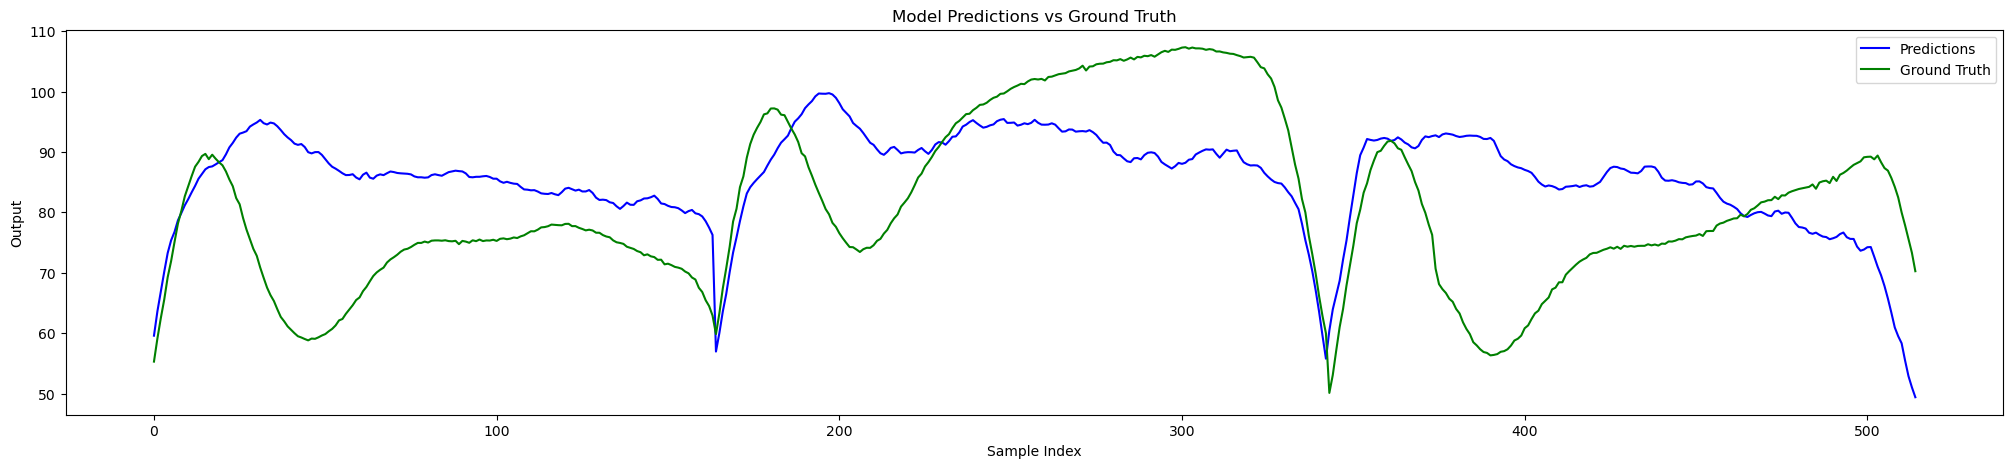

In [7]:
#whisker1 uncertainty aware mlp
from utils import evaluate
from model import *
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size=3, hidden_size=32, output_size=1, dropout_prob=0).to(device)
best_model_path='MLP_best_model_save/U_mlp_bs_32_lr_0.001_reg_0.001_do_0.1_rmse_12.8143_whisker1.pt'
model.load_state_dict(torch.load(best_model_path))
test_whisker_tensor = torch.Tensor(test_whisker1_filtered_N)
test_GT_tensor = torch.Tensor(test_GT1_filtered)
test_dataset = TensorDataset(test_whisker_tensor, test_GT_tensor)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_image_folder = 'MLP_test_image_save_whisker1'
os.makedirs(test_image_folder, exist_ok=True)
test_image_output_file = f'{test_image_folder}/whisker1.png'
RMSE, MAE, test_pre1 = evaluate(
        model,
        test_dataset,
        test_image_output_file)


print('RMSE                = {}'.format(RMSE))
print('MAE             = {}'.format(MAE))


RMSE                = 165.49927495507632
MAE             = 10.113477608736824


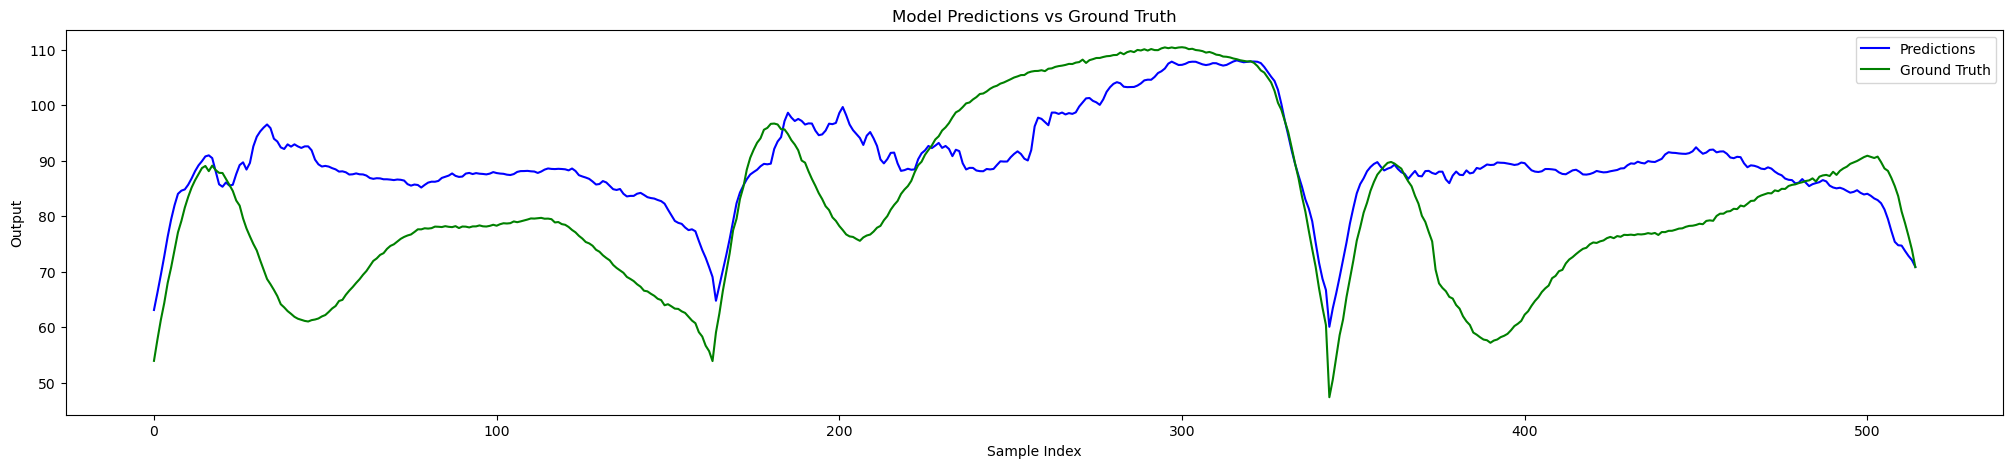

In [8]:
#whisker2 aware mlp
from utils import evaluate
from model import *
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size=3, hidden_size=32, output_size=1, dropout_prob=0.1).to(device)
best_model_path='MLP_best_model_save/U_mlp_bs_32_lr_0.001_reg_0.001_do_0.1_rmse_9.8377_whisker2.pt'
model.load_state_dict(torch.load(best_model_path))
test_whisker_tensor = torch.Tensor(test_whisker2_filtered_N)
test_GT_tensor = torch.Tensor(test_GT2_filtered)
test_dataset = TensorDataset(test_whisker_tensor, test_GT_tensor)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_image_folder = 'MLP_test_image_save_whisker2'
os.makedirs(test_image_folder, exist_ok=True)
test_image_output_file = f'{test_image_folder}/whisker2.png'
RMSE, MAE, test_pre2 = evaluate(
        model,
        test_dataset,
        test_image_output_file)


print('RMSE                = {}'.format(RMSE))
print('MAE             = {}'.format(MAE))

[array([59.59067], dtype=float32), array([63.60178242]), array([67.01876178]), array([70.07322254]), array([73.06377357]), array([75.85448462]), array([73.25427507]), array([71.71947135]), array([76.60496998]), array([79.29501555]), array([82.20374182]), array([84.34971706]), array([85.76157056]), array([88.36113286]), array([88.79247024]), array([89.21418584]), array([89.6260295]), array([90.15773277]), array([89.72830735]), array([89.16766217]), array([87.46586274]), array([87.02606664]), array([86.13583547]), array([85.50016506]), array([83.18657998]), array([81.61928119]), array([81.80111291]), array([80.89406521]), array([80.31106167]), array([79.78412294]), array([77.82003017]), array([77.59624983]), array([76.52174699]), array([75.21569061]), array([74.50852208]), array([74.44157963]), array([73.77951397]), array([73.02088808]), array([73.2270311]), array([73.47796461]), array([71.73369667]), array([72.33009182]), array([72.68513415]), array([72.49384816]), array([72.1476912]), 

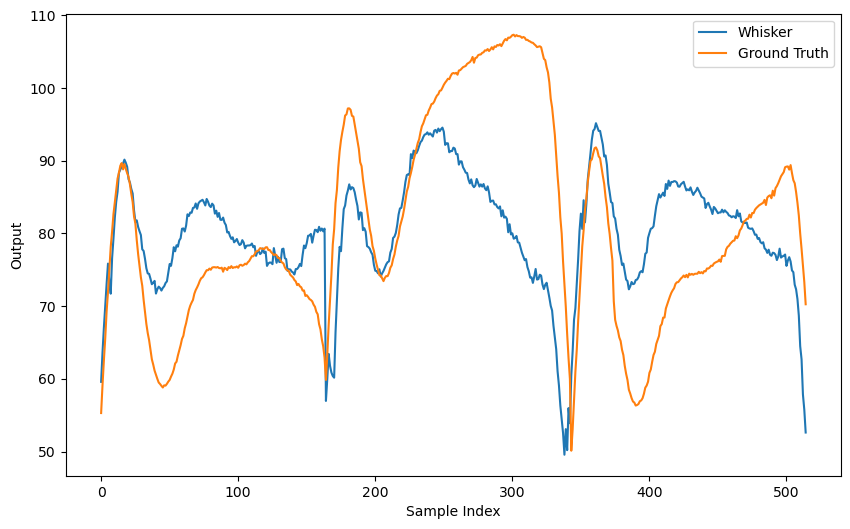

In [9]:
#KF Flat2 whisker1
import numpy as np
import os
import matplotlib.pyplot as plt
from KF import KalmanFilterFLAT2
from sklearn.metrics import mean_squared_error, mean_absolute_error

def apply_kalman_filterFLAT2(initial_state, initial_position, initial_yaw, test_pre, positions, yaws):
    kf = KalmanFilterFLAT2(initial_state, initial_position, initial_yaw, initial_covariance, process_noise, measurement_noise)
    estimates = [np.array([initial_state])]
    for z, position, yaw in zip(test_pre[1:], positions[1:], yaws[1:]):
        kf.predict(position, yaw)
        kf.update(np.array([240 - z]))
        estimates.append(kf.get_current_estimate())
    return estimates

# 数据分段
test_GT1_filtered_1 = test_GT1_filtered[0:164]
test_GT1_filtered_2 = test_GT1_filtered[164:343]
test_GT1_filtered_3 = test_GT1_filtered[343:515]
test_pre1_1 = test_pre1[0:164]
test_pre1_2 = test_pre1[164:343]
test_pre1_3 = test_pre1[343:515]
test_position1_1 = test_position_filtered[0:164]
test_position1_2 = test_position_filtered[164:343]
test_position1_3 = test_position_filtered[343:515]
test_yaw1_1 = test_orientation_filtered[0:164]
test_yaw1_2 = test_orientation_filtered[164:343]
test_yaw1_3 = test_orientation_filtered[343:515]
# 初始状态和噪声配置
initial_states = [test_pre1_1[0], test_pre1_2[0], test_pre1_3[0]]
initial_positions = [test_position1_1[0], test_position1_2[0], test_position1_3[0]]
initial_yaws = [test_yaw1_1[0], test_yaw1_2[0], test_yaw1_3[0]]
initial_covariance = np.array([[50]])
process_noise = np.array([[0.001]])
measurement_noise = np.array([[1]])

# 应用卡尔曼滤波
test_kal1_1 = apply_kalman_filterFLAT2(initial_states[0], initial_positions[0], initial_yaws[0], test_pre1_1, test_position1_1, test_yaw1_1)
test_kal1_2 = apply_kalman_filterFLAT2(initial_states[1], initial_positions[1], initial_yaws[1],test_pre1_2, test_position1_2, test_yaw1_2)
test_kal1_3 = apply_kalman_filterFLAT2(initial_states[2], initial_positions[2], initial_yaws[2],test_pre1_3, test_position1_3, test_yaw1_3)

# 合并结果
test_kal1 = test_kal1_1 + test_kal1_2 + test_kal1_3
print(test_kal1)
# 计算损失
MSE_loss = mean_squared_error(test_kal1, test_GT1_filtered)
MAE_loss = mean_absolute_error(test_kal1, test_GT1_filtered)

print(f'MSE = {MSE_loss}')
print(f'MAE = {MAE_loss}')

# 保存图像
test_image_folder = 'FLAT_MLP_KF_test_image_save_whisker1'
os.makedirs(test_image_folder, exist_ok=True)
test_image_output_file = f'{test_image_folder}/whisker1_kf_certainnoise_50_0.1_1.png'

plt.figure(figsize=(10, 6))
plt.plot(test_kal1, label='Whisker')
plt.plot(test_GT1_filtered, label='Ground Truth')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.savefig(test_image_output_file)

[array([63.080326], dtype=float32), array([66.17191506]), array([69.56025705]), array([72.62554699]), array([75.7335621]), array([78.78959075]), array([76.56456231]), array([75.31898467]), array([80.34112366]), array([83.01915128]), array([85.90169856]), array([88.0278851]), array([89.44330162]), array([92.03410154]), array([92.45536185]), array([92.87426109]), array([93.27167257]), array([93.75195597]), array([93.11027246]), array([92.2023275]), array([90.14287643]), array([89.36781913]), array([88.08244018]), array([87.05377076]), array([84.4290866]), array([82.62093874]), array([82.59356803]), array([81.4227787]), array([80.61276488]), array([79.98693832]), array([77.9901412]), array([77.75719026]), array([76.7245132]), array([75.48895248]), array([74.81042029]), array([74.70146286]), array([73.99829176]), array([73.1843476]), array([73.35266108]), array([73.61810601]), array([71.88911113]), array([72.53609845]), array([72.93336419]), array([72.76799353]), array([72.47393763]), arra

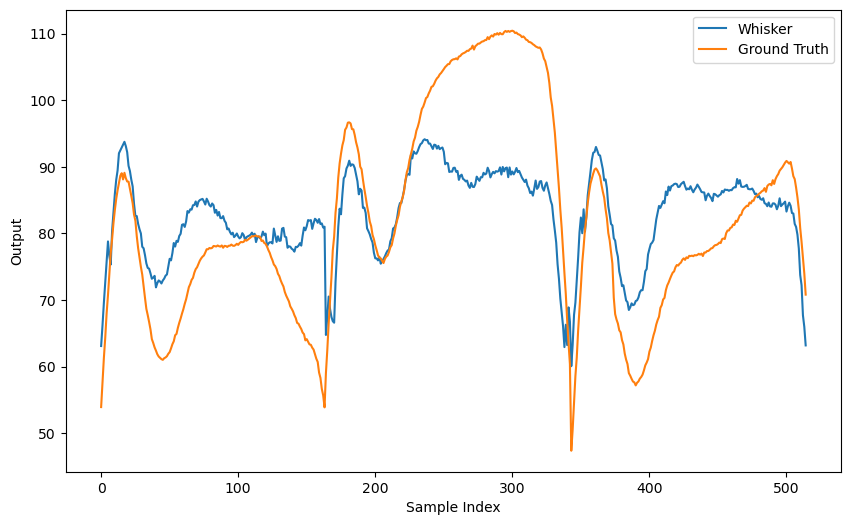

In [10]:
#KF Flat2 whisker2
import numpy as np
import os
import matplotlib.pyplot as plt
from KF import KalmanFilterFLAT2
from sklearn.metrics import mean_squared_error, mean_absolute_error

def apply_kalman_filterFLAT2(initial_state, initial_position, initial_yaw, test_pre, positions, yaws):
    kf = KalmanFilterFLAT2(initial_state, initial_position, initial_yaw, initial_covariance, process_noise, measurement_noise)
    estimates = [np.array([initial_state])]
    for z, position, yaw in zip(test_pre[1:], positions[1:], yaws[1:]):
        kf.predict(position, yaw)
        kf.update(np.array([240 - z]))
        estimates.append(kf.get_current_estimate())
    return estimates

# 数据分段
test_GT2_filtered_1 = test_GT2_filtered[0:164]
test_GT2_filtered_2 = test_GT2_filtered[164:343]
test_GT2_filtered_3 = test_GT2_filtered[343:515]
test_pre2_1 = test_pre2[0:164]
test_pre2_2 = test_pre2[164:343]
test_pre2_3 = test_pre2[343:515]
test_position2_1 = test_position_filtered[0:164]
test_position2_2 = test_position_filtered[164:343]
test_position2_3 = test_position_filtered[343:515]
test_yaw2_1 = test_orientation_filtered[0:164]
test_yaw2_2 = test_orientation_filtered[164:343] 
test_yaw2_3 = test_orientation_filtered[343:515] 
# 初始状态和噪声配置
initial_states = [test_pre2_1[0], test_pre2_2[0], test_pre2_3[0]]
initial_positions = [test_position2_1[0], test_position2_2[0], test_position2_3[0]]
initial_yaws = [test_yaw2_1[0], test_yaw2_2[0], test_yaw2_3[0]]
initial_covariance = np.array([[50]])
process_noise = np.array([[0.001]])
measurement_noise = np.array([[1]])

# 应用卡尔曼滤波
test_kal2_1 = apply_kalman_filterFLAT2(initial_states[0], initial_positions[0], initial_yaws[0], test_pre2_1, test_position2_1, test_yaw2_1)
test_kal2_2 = apply_kalman_filterFLAT2(initial_states[1], initial_positions[1], initial_yaws[1],test_pre2_2, test_position2_2, test_yaw2_2)
test_kal2_3 = apply_kalman_filterFLAT2(initial_states[2], initial_positions[2], initial_yaws[2],test_pre2_3, test_position2_3, test_yaw2_3)

# 合并结果
test_kal2 = test_kal2_1 + test_kal2_2 + test_kal2_3
print(test_kal2)
# 计算损失
MSE_loss = mean_squared_error(test_kal2, test_GT2_filtered)
MAE_loss = mean_absolute_error(test_kal2, test_GT2_filtered)

print(f'MSE = {MSE_loss}')
print(f'MAE = {MAE_loss}')

# 保存图像
test_image_folder = 'FLAT_MLP_KF_test_image_save_whisker2'
os.makedirs(test_image_folder, exist_ok=True)
test_image_output_file = f'{test_image_folder}/whisker2_kf_certainnoise_50_0.1_1.png'

plt.figure(figsize=(10, 6))
plt.plot(test_kal2, label='Whisker')
plt.plot(test_GT2_filtered, label='Ground Truth')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.savefig(test_image_output_file)

wall_rad = -0.08910968586948667
wall_rad = [-0.065519]
wall_rad = [-0.0639014]
wall_rad = [-0.0633749]
wall_rad = [-0.06601182]
wall_rad = [-0.07255881]
wall_rad = [-0.08209784]
wall_rad = [-0.08944924]
wall_rad = [-0.09263275]
wall_rad = [-0.09208001]
wall_rad = [-0.09094638]
wall_rad = [-0.08977625]
wall_rad = [-0.08904029]
wall_rad = [-0.08776888]
wall_rad = [-0.08580997]
wall_rad = [-0.08389415]
wall_rad = [-0.08138876]
wall_rad = [-0.07772795]
wall_rad = [-0.0704503]
wall_rad = [-0.0597818]
wall_rad = [-0.04864396]
wall_rad = [-0.03785834]
wall_rad = [-0.02577662]
wall_rad = [-0.01381743]
wall_rad = [-0.00360921]
wall_rad = [0.0047117]
wall_rad = [0.01250765]
wall_rad = [0.02121546]
wall_rad = [0.02937011]
wall_rad = [0.03448195]
wall_rad = [0.03835712]
wall_rad = [0.04137543]
wall_rad = [0.04331897]
wall_rad = [0.04471865]
wall_rad = [0.04671139]
wall_rad = [0.04991925]
wall_rad = [0.05299777]
wall_rad = [0.05626156]
wall_rad = [0.05908435]
wall_rad = [0.06087729]
wall_rad = [0.0

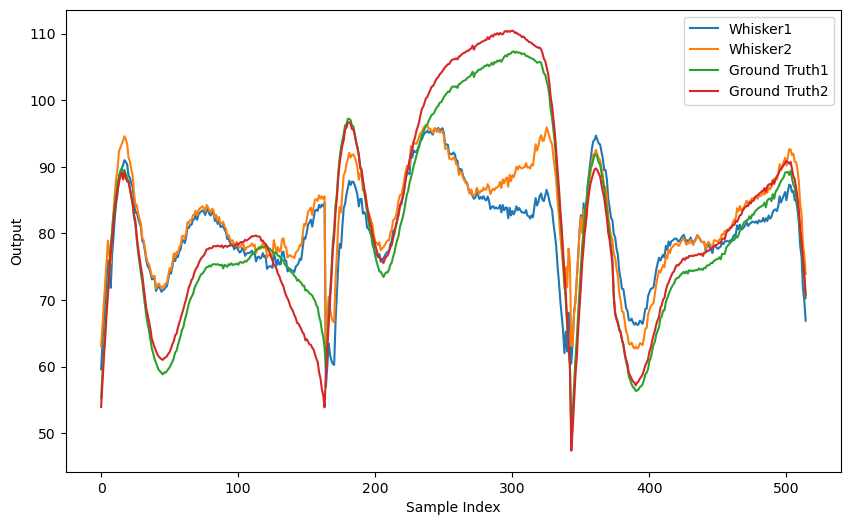

In [ ]:
#KF Flat3_seperate whisker1 and whisker2
import numpy as np
import os
import matplotlib.pyplot as plt
from KF import KalmanFilterFLAT3_seperate
from sklearn.metrics import mean_squared_error, mean_absolute_error

def apply_kalman_filterFLAT3(initial_state1, initial_state2, initial_position, initial_yaw, test_pre1, test_pre2, positions, yaws, fading_factor):
    kf = KalmanFilterFLAT3_seperate(initial_state1, initial_state2, initial_position, initial_yaw, initial_covariance, process_noise, measurement_noise, fading_factor)
    estimates1 = [np.array([initial_state1])]
    estimates2 = [np.array([initial_state2])]
    for z1, z2, position, yaw in zip(test_pre1[1:], test_pre2[1:], positions[1:], yaws[1:]):
        kf.predict(position, yaw)
        kf.update(np.array([240 - z1]), np.array([240 - z2]))
        estimate1, estimate2 = kf.get_current_estimate()
        estimates1.append(estimate1)
        estimates2.append(estimate2)
    return estimates1, estimates2

fading_factor = 1


# 数据分段 whisker1
test_GT1_filtered_1 = test_GT1_filtered[0:164]
test_GT1_filtered_2 = test_GT1_filtered[164:343]
test_GT1_filtered_3 = test_GT1_filtered[343:515]
test_pre1_1 = test_pre1[0:164]
test_pre1_2 = test_pre1[164:343]
test_pre1_3 = test_pre1[343:515]

# 数据分段 whisker2
test_GT2_filtered_1 = test_GT2_filtered[0:164]
test_GT2_filtered_2 = test_GT2_filtered[164:343]
test_GT2_filtered_3 = test_GT2_filtered[343:515]
test_pre2_1 = test_pre2[0:164]
test_pre2_2 = test_pre2[164:343]
test_pre2_3 = test_pre2[343:515]

# 数据分段 both
test_position_1 = test_position_filtered[0:164]
test_position_2 = test_position_filtered[164:343]
test_position_3 = test_position_filtered[343:515]
test_yaw_1 = test_orientation_filtered[0:164] 
test_yaw_2 = test_orientation_filtered[164:343] 
test_yaw_3 = test_orientation_filtered[343:515] 

# 初始状态和噪声配置
initial_states1 = [test_pre1_1[0], test_pre1_2[0], test_pre1_3[0]]
initial_states2 = [test_pre2_1[0], test_pre2_2[0], test_pre2_3[0]]
initial_positions = [test_position_1[0], test_position_2[0], test_position_3[0]]
initial_yaws = [test_yaw_1[0], test_yaw_2[0], test_yaw_3[0]]
initial_covariance = np.array([[50]])
process_noise = np.array([[0.0002]])
measurement_noise = np.array([[1]])

# 应用卡尔曼滤波
test_kal1_1, test_kal2_1= apply_kalman_filterFLAT3(initial_states1[0], initial_states2[0], initial_positions[0], initial_yaws[0], test_pre1_1, test_pre2_1, test_position_1, test_yaw_1, fading_factor)
test_kal1_2, test_kal2_2= apply_kalman_filterFLAT3(initial_states1[1], initial_states2[0], initial_positions[1], initial_yaws[1], test_pre1_2, test_pre2_2, test_position_2, test_yaw_2, fading_factor)
test_kal1_3, test_kal2_3= apply_kalman_filterFLAT3(initial_states1[2], initial_states2[0], initial_positions[2], initial_yaws[2], test_pre1_3, test_pre2_3, test_position_3, test_yaw_3, fading_factor)

# 合并结果
test_kal1 = test_kal1_1 + test_kal1_2 + test_kal1_3
test_kal2 = test_kal2_1 + test_kal2_2 + test_kal2_3
print(test_kal1)
print(test_kal2)
# 计算损失
MSE_loss_1 = mean_squared_error(test_kal1, test_GT1_filtered)
MAE_loss_1 = mean_absolute_error(test_kal1, test_GT1_filtered)
MSE_loss_2 = mean_squared_error(test_kal2, test_GT2_filtered)
MAE_loss_2 = mean_absolute_error(test_kal2, test_GT2_filtered)

print(f'whisker1 MSE = {MSE_loss_1}')
print(f'whisker1 MAE = {MAE_loss_1}')
print(f'whisker2 MSE = {MSE_loss_2}')
print(f'whisker2 MAE = {MAE_loss_2}')

# 保存图像
test_image_folder = 'FLAT3_MLP_KF_test_image_save_whisker1+2'
os.makedirs(test_image_folder, exist_ok=True)
test_image_output_file_1 = f'{test_image_folder}/p_0.05_noise_1e-2_modelvarianceweight_1_whisker1_kf_certainnoise_50_0.1_1_1.png'

plt.figure(figsize=(10, 6))
# plt.plot(test_kal, label='Whisker')
plt.plot(test_kal1, label='Whisker1')
plt.plot(test_kal2, label='Whisker2')
plt.plot(test_GT1_filtered, label='Ground Truth1')
plt.plot(test_GT2_filtered, label='Ground Truth2')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.savefig(test_image_output_file)


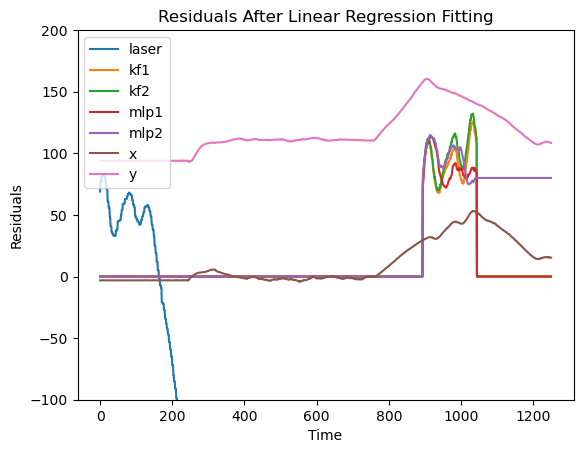

In [43]:
data = pd.read_csv('20240918/2024-12-10+10:41:08+.csv')
data1 = data.iloc[500:750, 13].values
data2 = data.iloc[500:750, 16].values
data3 = data.iloc[500:750, 14].values
data4 = data.iloc[500:, 17].values
data5 = data.iloc[500:, 15].values
data6 = data.iloc[500:, 18].values
data6 = data.iloc[500:, 18].values
data7 = data.iloc[900:1250, -3].values
data8 = data.iloc[500:, -3].values
data9 = data.iloc[:1250, -2].values
data10 = data.iloc[:1250, -1].values
data11 = data.iloc[:1250, -8].values
data12 = data.iloc[:1250, -7].values
x = data.iloc[:1250, 1].values
y = data.iloc[:1250, 2].values
# plt.plot(data1, label="whisker1_1", alpha=0.7)
# plt.plot(data2, label="whisker2_1", alpha=0.7)
# plt.plot(data3, label="whisker1_2", alpha=0.7)
# plt.plot(data4, label="whisker2_2", alpha=0.7)
# plt.plot(data5, label="whisker1_3", alpha=0.7)
# plt.plot(data6, label="whisker2_3", alpha=0.7)
plt.plot(218 - data7, label="laser")
# plt.plot(data8*10000 - 3000, label="Y")
plt.plot(data9, label="kf1")
plt.plot(data10, label="kf2")
plt.plot(data11, label="mlp1")
plt.plot(data12, label="mlp2")
plt.plot(x*100, label="x")
plt.plot(y*100, label="y")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 200)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

(2780, 27)
Index(['timeTick', ' stateX', ' stateY', ' stateZ', ' stateVX', ' stateVY',
       ' stateVZ', ' whisker1_1', ' whisker1_2', ' whisker1_3', ' whisker2_1',
       ' whisker2_2', ' whisker2_3', ' prewhisker1_1', ' prewhisker1_2',
       ' prewhisker1_3', ' prewhisker2_1', ' prewhisker2_2', ' prewhisker2_3',
       ' MLPwhisker1', ' MLPwhisker2', ' stateouterloop', ' gpislabel', ' yaw',
       ' laserFront', ' KFwhisker1', ' KFwhisker2'],
      dtype='object')
wall_rad = 0.14353931825168442
wall_rad = [0.10115538]
wall_rad = [0.08666863]
wall_rad = [0.08291446]
wall_rad = [0.08592099]
wall_rad = [0.08606917]
wall_rad = [0.08456162]
wall_rad = [0.0819112]
wall_rad = [0.07769779]
wall_rad = [0.07126691]
wall_rad = [0.06365547]
wall_rad = [0.05802871]
wall_rad = [0.05315027]
wall_rad = [0.0466292]
wall_rad = [0.03865776]
wall_rad = [0.03088456]
wall_rad = [0.02422998]
wall_rad = [0.02019911]
wall_rad = [0.01670126]
wall_rad = [0.01207101]
wall_rad = [0.006792]
wall_rad = [0.001865

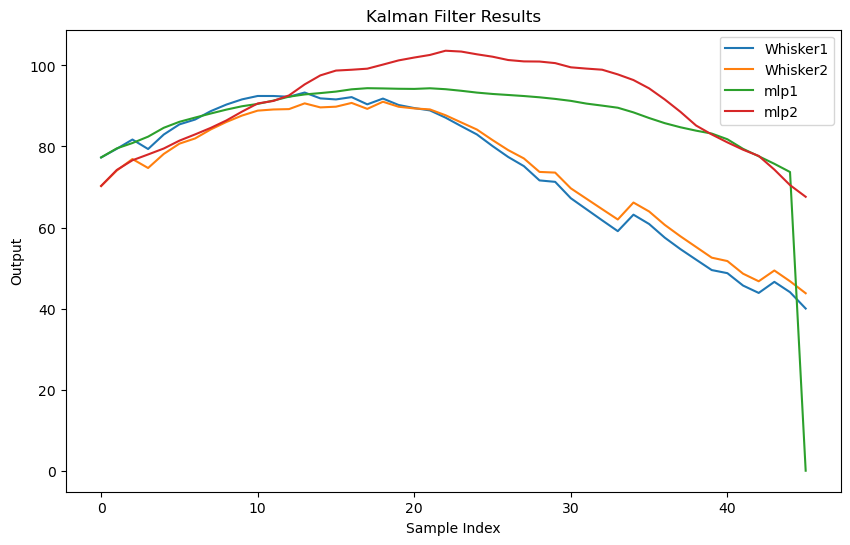

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from KF import KalmanFilterFLAT3_seperate  # 确保类已正确定义

# 读取数据
data = pd.read_csv('20240918/2024-12-09+21:33:59+.csv')

# 检查数据维度
print(data.shape)
print(data.columns)

# 数据分段
test_pre1_1 = data.iloc[929:975, -8].values
test_pre2_1 = data.iloc[929:975, -7].values
test_position_1 = data.iloc[929:975, 1:3].values
test_yaw_1 = data.iloc[929:975, -4].values

# 参数配置
fading_factor = 0.98
initial_states1 = [test_pre1_1[0]]
initial_states2 = [test_pre2_1[0]]
initial_positions = [test_position_1[0]]
initial_yaws = [test_yaw_1[0]] 
initial_covariance = np.array([[50]])
process_noise = np.array([[0.0002]])
measurement_noise = np.array([[1]])

# 应用卡尔曼滤波
test_kal1_1, test_kal2_1 = apply_kalman_filterFLAT3(
    initial_states1[0],
    initial_states2[0],
    initial_positions[0],
    initial_yaws[0],
    test_pre1_1,
    test_pre2_1,
    test_position_1,
    test_yaw_1,
    fading_factor
)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(test_kal1_1, label='Whisker1')
plt.plot(test_kal2_1, label='Whisker2')
plt.plot(test_pre1_1, label='mlp1')
plt.plot(test_pre2_1, label='mlp2')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.title('Kalman Filter Results')
plt.show()

In [238]:

model = torch.load('MLP_best_model_save/all2.pt')

def print_weights_as_c_array(state_dict):
    print('#include <stdio.h>\n')  # C语言文件的头部

    for name, param in state_dict.items():
        # 检查是否是二维权重
        if param.ndim == 2:  # 全连接层的权重
            # 打印每层的名称和对应的二维权重
            print(f'const float {name} = {{')
            param_data = param.cpu().numpy()  # 获取权重并转为 NumPy 数组
            for row in param_data:
                print('    {' + ', '.join(map(str, row)) + '},')  # 按行输出二维数组
            print('};\n')

        elif param.ndim == 1:  # 偏置项（通常是一维数组）
            print(f'const float {name} = {{')
            param_data = param.cpu().numpy()  # 获取偏置并转为 NumPy 数组
            print('    ' + ', '.join(map(str, param_data)) + ',')  # 输出一维数组
            print('};\n')

# 调用函数打印模型的权重
# 调用函数打印模型的权重
print_weights_as_c_array(model)


#include <stdio.h>

const float fc1.weight = {
    {0.352836, 0.22396527, -0.3881541},
    {-0.3725905, -0.042327747, -0.35681954},
    {-0.5092511, 0.46264827, -0.29089087},
    {0.5879405, 0.5802999, -0.14628054},
    {0.20971267, 0.22329623, -0.5255242},
    {0.17554894, 0.068195485, -0.071833014},
    {0.47015113, 0.29399538, 0.03130869},
    {-0.20411421, -0.45878828, -0.40662786},
    {-0.22821388, 0.48899254, 0.29580206},
    {0.1784923, -0.19142307, 0.34477773},
    {0.1169006, -0.26205426, -0.48093042},
    {-0.47426745, 0.073332414, -0.26331976},
    {-0.6540984, 0.19089875, 0.3983744},
    {0.43401352, 0.19195305, 0.42619336},
    {-0.0015662587, -0.1849673, -0.3394034},
    {0.04013724, -0.1156585, 0.03404924},
    {-0.13833904, -0.047672804, 0.3528682},
    {0.03703002, 0.17412874, -0.2711112},
    {0.2070934, -0.09939227, -0.23909481},
    {0.4056244, -0.29193112, -0.33276978},
    {-0.46099308, 0.3996501, 0.74033713},
    {-0.12593617, -0.40395322, 0.3424109},
    {-0.08

In [6]:
print(calculate_distance_to_line(0.639973759651184,-1.95227956771851, np.rad2deg(-0.146386876101629)- 0.064))

0.12443213819136777


In [7]:
x1, y1 =  -2.240269,0.749876

x2, y2 =  -0.986052, 0.811162



# Calculate the angle with respect to the X-axis

delta_x = x2 - x1

delta_y = y2 - y1



# Angle in radians

angle_radians = math.atan2(delta_y, delta_x)



# Convert to degrees

angle_degrees = math.degrees(angle_radians)
print(angle_degrees)

2.797473172728386


In [8]:
calculate_distance_to_line

<function __main__.calculate_distance_to_line(xp, yp, yaw, x1=0.749876, y1=-2.240269, x2=0.811162, y2=-0.986052)>